In [1]:
#Connect to Google Drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Download and install resnet3D CNN builder
!pip install git+https://github.com/JihongJu/keras-resnet3d.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JihongJu/keras-resnet3d.git to /tmp/pip-req-build-rrnf8jap
  Running command git clone -q https://github.com/JihongJu/keras-resnet3d.git /tmp/pip-req-build-rrnf8jap
  Running command git submodule update --init --recursive -q
  Created wheel for keras-resnet3d: filename=keras_resnet3d-0.0.1-py3-none-any.whl size=4765 sha256=87f9f9f4afb19b85b94f31c0e08ee309295c0d6edb8bb9a90888ebc06ea845ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-rl1cnz2q/wheels/7e/d8/d8/79a8e9fdfacb40c998db593c423f1dd764cd65ceb66246d6f1
Successfully built keras-resnet3d


In [2]:
#Import Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,Rescaling
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow import keras
from tensorflow.keras import layers
#from resnet3d import Resnet3DBuilder

# 2D CNN Models

In [6]:
#Divide the images to train, validation and test datasets
from tensorflow.keras.utils import image_dataset_from_directory

#Train Dataset
train_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/MSc Project Datasets/2D_MRI_Images/Skullstripped_Non_Registered_5slice_Coronal/Train",
    label_mode='categorical',
    validation_split=0.2,
    image_size = (170,256),
    subset="training",
    seed=13,
    batch_size=32
)

#Validation Dataset
val_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/MSc Project Datasets/2D_MRI_Images/Skullstripped_Non_Registered_5slice_Coronal/Train",
    label_mode='categorical',
    validation_split=0.2,
    image_size = (170,256),
    subset="validation",
    seed=13,
    batch_size=32
)

#Test Dataset
test_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/MSc Project Datasets/2D_MRI_Images/Skullstripped_Non_Registered_5slice_Coronal/Test",
    label_mode='categorical',
    image_size = (170,256),
    seed=13,
    batch_size=32)

Found 2720 files belonging to 3 classes.
Using 2176 files for training.
Found 2720 files belonging to 3 classes.
Using 544 files for validation.
Found 680 files belonging to 3 classes.


# VGG 16 CNN Model

In [ ]:
#VGG16 model with the last 4 layers unfrozen 
conv_base = keras.applications.vgg16.VGG16(
    input_shape = (170,256,3),
    weights = "imagenet",
    include_top = False
)
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [ ]:
#Data augmentation layer
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomTranslation(height_factor=(-0.05,0.05),
                           width_factor=(-0.05,0.05))
])

In [ ]:
#Metrics to be calculated Accuracy and AUC Score
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]


In [ ]:
#VGG16 model


inputs = keras.Input(shape=(170,256,3))
#Data augmentation
input = data_augmentation(inputs)
#Preprocess Input
x = keras.applications.vgg16.preprocess_input(input)
#VGG16 CNN base
x = conv_base(x)
#Flatten CNN output
x = Flatten()(x)
#Dense layer with RELU activation
x = Dense(512,activation="relu")(x)
#Dropout Layer
x = Dropout(0.5)(x)
#3 way Classification dense layer with softmax activation
outputs = Dense(3,activation="softmax")(x)
model = keras.Model(inputs,outputs)

#Model Compilation
model.compile(loss= keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              metrics = METRICS)

In [ ]:
#Callback for VGG16 model
filepath = "vgg16withinbuitpreprocess.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only=True,
        mode = "max",
        monitor="val_acc"
    )
]

In [ ]:
#Fitting the model to obtain training and validation accuracy and AUC score
from sklearn.utils import class_weight
history= model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/40
68/68 [==============================] - 15s 204ms/step - loss: 1.2956 - acc: 0.6944 - auc: 0.7791 - val_loss: 0.7430 - val_acc: 0.7261 - val_auc: 0.8515
Epoch 2/40
68/68 [==============================] - 14s 201ms/step - loss: 0.7203 - acc: 0.7238 - auc: 0.8578 - val_loss: 0.7204 - val_acc: 0.7390 - val_auc: 0.8770
Epoch 3/40
68/68 [==============================] - 14s 199ms/step - loss: 0.6375 - acc: 0.7335 - auc: 0.8916 - val_loss: 0.6335 - val_acc: 0.7445 - val_auc: 0.8967
Epoch 4/40
68/68 [==============================] - 13s 190ms/step - loss: 0.5655 - acc: 0.7551 - auc: 0.9156 - val_loss: 0.8052 - val_acc: 0.7353 - val_auc: 0.9041
Epoch 5/40
68/68 [==============================] - 14s 198ms/step - loss: 0.4664 - acc: 0.8056 - auc: 0.9423 - val_loss: 0.4829 - val_acc: 0.8088 - val_auc: 0.9395
Epoch 6/40
68/68 [==============================] - 13s 191ms/step - loss: 0.3706 - acc: 0.8534 - auc: 0.9638 - val_loss: 0.4772 - val_acc: 0.7978 - val_auc: 0.9401
Epoch 7/40

In [ ]:
#Obtaining Test Accuracy and AUC score
from keras.models import Sequential, load_model
model = load_model(filepath)
testscores = model.evaluate(test_dataset)
print(f"Accuracy = {testscores[1]*100}, AUC Score = {testscores[2]} ")

22/22 [==============================] - 3s 132ms/step - loss: 1.6937 - acc: 0.7794 - auc: 0.8706
Accuracy = 77.9411792755127, AUC Score = 0.8706395030021667 


In [ ]:
#unpacking predictions and labels
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [ ]:
#Confusion Matrix
cf_matrix = confusion_matrix(labels, predictions)

In [ ]:
#Confusion Matrix Plotting function
def plot_confusion_matrix(cf_matrix):
  fig, ax = plt.subplots(figsize=(8,6))
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

  ax.set_title('Confusion Matrix \n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['AD','MCI','NL'])
  ax.yaxis.set_ticklabels(['AD','MCI','NL'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

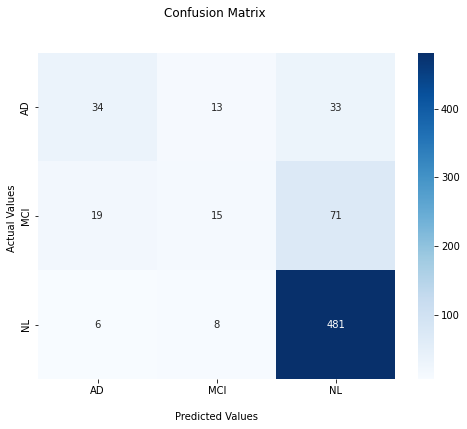

In [ ]:
#Confusion Matrix of VGG16 model
plot_confusion_matrix(cf_matrix)

In [ ]:
#Model loss plotting Function
def plot_model_loss(history):
  plt.figure(figsize=(8, 8))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

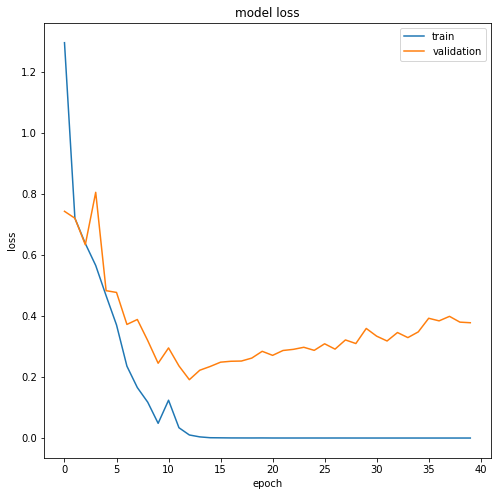

In [ ]:
#Model Loss graph of VGG16 model
plot_model_loss(history)

In [ ]:
#Model Accuracy plotting Function
def plot_model_accuracy(history):
  plt.figure(figsize=(8, 8))
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

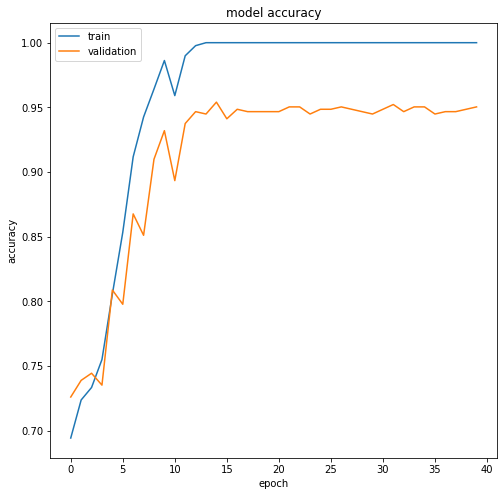

In [ ]:
#Model accruacy graph of VGG16 model
plot_model_accuracy(history)

# Inception Resnet V2 CNN Model

In [ ]:
#Inception resnet V2 model with the last 75 layers unfrozen 
conv_base2 = keras.applications.InceptionResNetV2(
    input_shape = (170,256,3),
    weights = "imagenet",
    include_top = False
)
conv_base2.trainable = False

for layer in conv_base2.layers[-75:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
#Inception resnet V2 model

inputs = keras.Input(shape=(170,256,3))
input = data_augmentation(input)
x = keras.applications.inception_resnet_v2.preprocess_input(inputs)
x = conv_base2(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(3,activation="softmax")(x)
model = keras.Model(inputs,outputs)
model.compile(loss= keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              metrics = METRICS)

In [ ]:
#Inception resnet V2 model callaback
filepath = "resnetwithinbuitpreprocess.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only=True,
        monitor="val_acc"
    )
]

In [ ]:
#Inception resnet V2 model fit
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/40
68/68 [==============================] - 28s 263ms/step - loss: 4.4529 - acc: 0.6949 - auc: 0.8204 - val_loss: 1.7386 - val_acc: 0.6783 - val_auc: 0.8313
Epoch 2/40
68/68 [==============================] - 15s 215ms/step - loss: 1.8425 - acc: 0.6930 - auc: 0.8437 - val_loss: 1.1925 - val_acc: 0.7610 - val_auc: 0.8909
Epoch 3/40
68/68 [==============================] - 13s 195ms/step - loss: 1.6753 - acc: 0.7298 - auc: 0.8592 - val_loss: 2.3836 - val_acc: 0.7592 - val_auc: 0.8490
Epoch 4/40
68/68 [==============================] - 15s 213ms/step - loss: 1.4259 - acc: 0.7707 - auc: 0.8875 - val_loss: 1.1731 - val_acc: 0.7978 - val_auc: 0.9081
Epoch 5/40
68/68 [==============================] - 13s 194ms/step - loss: 1.0408 - acc: 0.8093 - auc: 0.9219 - val_loss: 1.3071 - val_acc: 0.7114 - val_auc: 0.8624
Epoch 6/40
68/68 [==============================] - 15s 215ms/step - loss: 0.8517 - acc: 0.8304 - auc: 0.9316 - val_loss: 1.0213 - val_acc: 0.8401 - val_auc: 0.9207
Epoch 7/40

In [ ]:
#Inception resnet V2 model test accuracy and AUC score
from keras.models import Sequential, load_model
testscores = model.evaluate(test_dataset)
print(f"Accuracy = {testscores[1]*100}, AUC Score = {testscores[2]} ")

22/22 [==============================] - 4s 149ms/step - loss: 3.8867 - acc: 0.7029 - auc: 0.8128
Accuracy = 70.29411792755127, AUC Score = 0.8127984404563904 


In [ ]:
#unpacking predictions and labels
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

#Confusion Matrix
cf_matrix = confusion_matrix(labels, predictions)

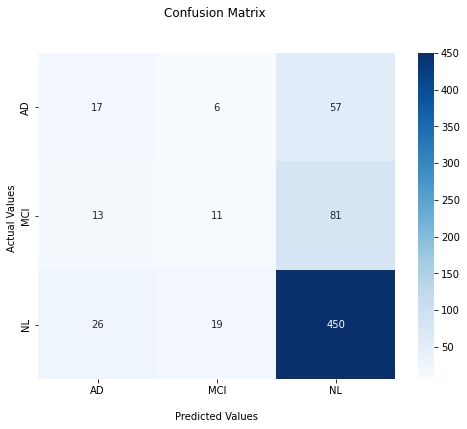

In [ ]:
#Inception resnet V2 model confusion matrix
plot_confusion_matrix(cf_matrix)

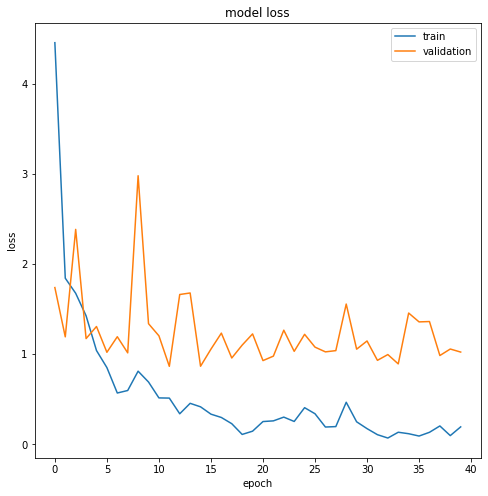

In [ ]:
#Inception resnet V2 model model loss graph
plot_model_loss(history)

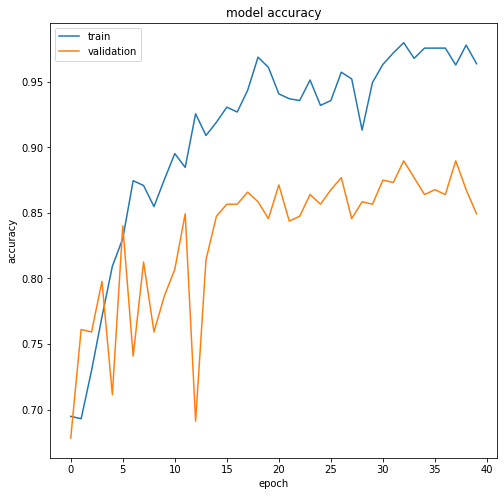

In [ ]:
#Inception resnet V2 model model accuracy graph
plot_model_accuracy(history)

# EfficientNet B1 CNN Model

In [ ]:
#EfficientNet B1 model with the last 75 layers unfrozen 
conv_base3 = keras.applications.EfficientNetB1(
    input_shape = (170,256,3),
    weights = "imagenet",
    include_top = False
)
conv_base3.trainable = False

for layer in conv_base3.layers[-75:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

27033600/27018416 [==============================] - 1s 0us/step


In [ ]:
#EfficientNet B1 model 

inputs = keras.Input(shape=(170,256,3))
input = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(input)
x = conv_base3(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(3,activation="softmax")(x)
model = keras.Model(inputs,outputs)
model.compile(loss= keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              metrics = METRICS)

In [ ]:
#EfficientNet B1 model callback
filepath = "efficientnetwithinbuitpreprocess.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only=True,
        monitor="val_acc"
    )
]

In [ ]:
#EfficientNet B1 model fit
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    callbacks= callbacks
)

Epoch 1/40
68/68 [==============================] - 19s 156ms/step - loss: 4.2048 - acc: 0.6614 - auc: 0.7917 - val_loss: 1.1029 - val_acc: 0.7335 - val_auc: 0.8787
Epoch 2/40
68/68 [==============================] - 8s 121ms/step - loss: 2.4502 - acc: 0.6801 - auc: 0.8200 - val_loss: 1.8611 - val_acc: 0.7684 - val_auc: 0.8622
Epoch 3/40
68/68 [==============================] - 8s 111ms/step - loss: 1.8905 - acc: 0.7293 - auc: 0.8524 - val_loss: 1.0865 - val_acc: 0.7040 - val_auc: 0.8643
Epoch 4/40
68/68 [==============================] - 8s 110ms/step - loss: 2.0516 - acc: 0.7381 - auc: 0.8563 - val_loss: 0.9830 - val_acc: 0.7684 - val_auc: 0.8993
Epoch 5/40
68/68 [==============================] - 8s 120ms/step - loss: 1.6892 - acc: 0.7702 - auc: 0.8834 - val_loss: 0.6310 - val_acc: 0.8309 - val_auc: 0.9448
Epoch 6/40
68/68 [==============================] - 8s 109ms/step - loss: 1.3333 - acc: 0.7937 - auc: 0.9020 - val_loss: 1.6071 - val_acc: 0.7978 - val_auc: 0.8869
Epoch 7/40
68/6

In [ ]:
#EfficientNet B1 model test accuracy and AUC score
from keras.models import Sequential, load_model
testscores = model.evaluate(test_dataset)
print(f"Accuracy = {testscores[1]*100}, AUC Score = {testscores[2]} ")

22/22 [==============================] - 2s 82ms/step - loss: 5.0747 - acc: 0.6765 - auc: 0.7778
Accuracy = 67.64705777168274, AUC Score = 0.777795135974884 


In [ ]:
#unpacking predictions and labels
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

#Confusion Matrix
cf_matrix = confusion_matrix(labels, predictions)

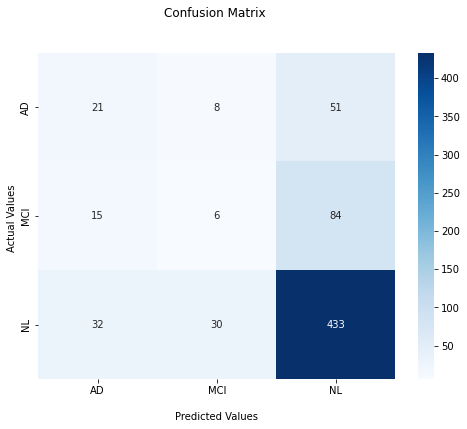

In [ ]:
#EfficientNet B1 model confusion matrix
plot_confusion_matrix(cf_matrix)

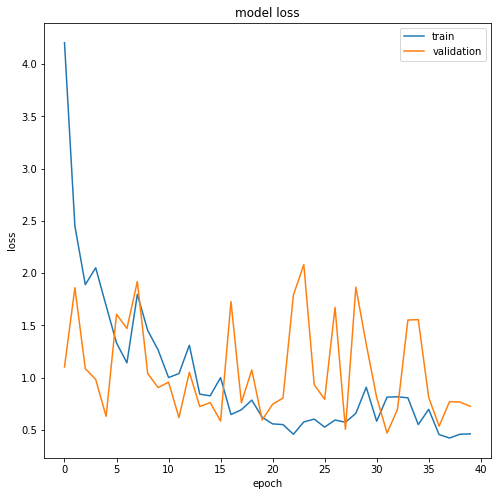

In [ ]:
#EfficientNet B1 model model loss graph
plot_model_loss(history)

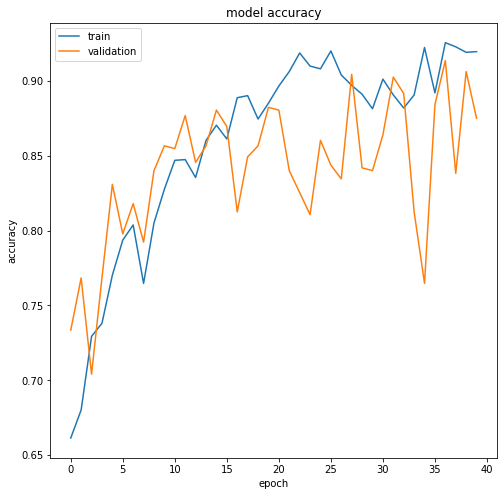

In [ ]:
#EfficientNet B1 model model accuracy graph
plot_model_accuracy(history)

# Inception V3 CNN Model

In [ ]:
#Inception V3 model with the last 75 layers unfrozen 
conv_base4 = keras.applications.InceptionV3(
    input_shape = (170,256,3),
    weights = "imagenet",
    include_top = False
)
conv_base4.trainable = False

for layer in conv_base4.layers[-75:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
#Inception V3 model

inputs = keras.Input(shape=(170,256,3))
input = data_augmentation(inputs)
x = keras.applications.inception_v3.preprocess_input(input)
x = conv_base4(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(3,activation="softmax")(x)
model = keras.Model(inputs,outputs)
model.compile(loss= keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              metrics = METRICS)



In [ ]:
#Inception V3 model callback
filepath = "inceptionwithinbuitpreprocess.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only=True,
        mode="max",
        monitor="val_acc"
    )
]

In [ ]:
#Inception V3 model fit
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/40
68/68 [==============================] - 13s 115ms/step - loss: 4.2300 - acc: 0.6831 - auc: 0.8084 - val_loss: 1.4155 - val_acc: 0.7059 - val_auc: 0.8644
Epoch 2/40
68/68 [==============================] - 7s 99ms/step - loss: 2.3105 - acc: 0.7146 - auc: 0.8392 - val_loss: 1.4862 - val_acc: 0.7702 - val_auc: 0.8768
Epoch 3/40
68/68 [==============================] - 6s 89ms/step - loss: 1.7534 - acc: 0.7615 - auc: 0.8765 - val_loss: 3.4668 - val_acc: 0.7647 - val_auc: 0.8525
Epoch 4/40
68/68 [==============================] - 7s 98ms/step - loss: 1.4079 - acc: 0.8079 - auc: 0.9030 - val_loss: 1.8548 - val_acc: 0.8051 - val_auc: 0.8847
Epoch 5/40
68/68 [==============================] - 6s 88ms/step - loss: 0.9893 - acc: 0.8378 - auc: 0.9308 - val_loss: 1.6099 - val_acc: 0.7316 - val_auc: 0.8590
Epoch 6/40
68/68 [==============================] - 7s 98ms/step - loss: 1.0003 - acc: 0.8451 - auc: 0.9304 - val_loss: 1.6595 - val_acc: 0.8272 - val_auc: 0.8988
Epoch 7/40
68/68 [==

In [ ]:
#Inception V3 model test accuracy and AUC score
from keras.models import Sequential, load_model

testscores = model.evaluate(test_dataset)
print(f"Accuracy = {testscores[1]*100}, AUC Score = {testscores[2]} ")

22/22 [==============================] - 2s 91ms/step - loss: 7.5827 - acc: 0.7000 - auc: 0.7944
Accuracy = 69.9999988079071, AUC Score = 0.7943576574325562 


In [ ]:
#unpacking predictions and labels
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

#Confusion Matrix
cf_matrix = confusion_matrix(labels, predictions)

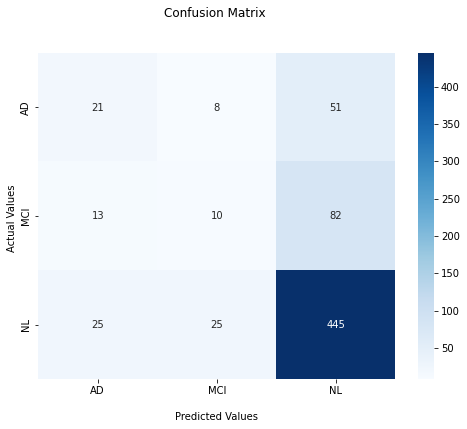

In [ ]:
#Inception V3 model confusion matrix
plot_confusion_matrix(cf_matrix)

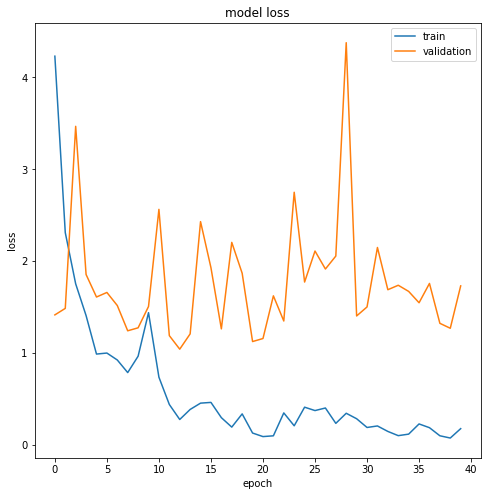

In [ ]:
#Inception V3 model loss graph
plot_model_loss(history)

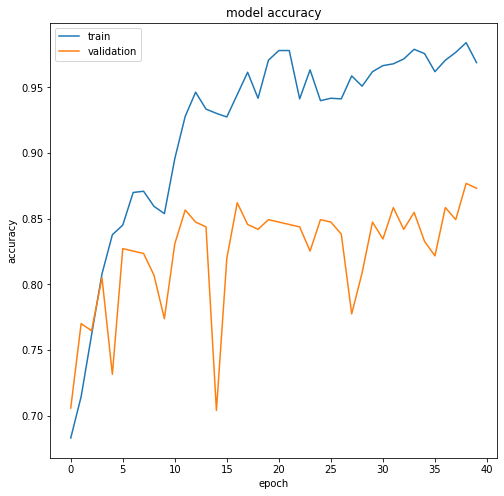

In [ ]:
#Inception V3 model accuracy graph
plot_model_accuracy(history)

# 3D CNN models

In [ ]:
import nibabel as nib
import os

from scipy import ndimage

#Function to read 3D MRI images and convert to array

def read_3DMRI_file(filepath):
    """Read 3D MRI images and convert to array
    Args:
        filepath: Path of 3D image file

    
    """
    #Read 3D MRI image
    MRI = nib.load(filepath)

    #Convert 3D MRI image to array
    MRIarray = scan.get_fdata()

    #Return MRI array
    return MRIarray

In [ ]:
#Obtain paths of test dataset images

srcpath = "/content/drive/MyDrive/MSc Project Datasets/3D_MRI_Images/Registered_3D_MRI_for_3DCNN/Test"
testpaths = [] 

for (root,dirs,files) in os.walk(srcpath, topdown=True):
      for file in files:
          paths = os.path.join(root,file)
          testpaths.append(paths)
    

In [ ]:
#Obtain paths of train dataset images

srcpath = "/content/drive/MyDrive/MSc Project Datasets/3D_MRI_Images/Registered_3D_MRI_for_3DCNN/Train"
trainpaths = [] 

for (root,dirs,files) in os.walk(srcpath, topdown=True):
      for file in files:
          paths = os.path.join(root,file)
          trainpaths.append(paths)
        

In [ ]:
#Obtain paths of validation dataset images

srcpath = "/content/drive/MyDrive/MSc Project Datasets/3D_MRI_Images/Registered_3D_MRI_for_3DCNN/Validation"
validpaths = [] 

for (root,dirs,files) in os.walk(srcpath, topdown=True):
      for file in files:
          paths = os.path.join(root,file)
          validpaths.append(paths)
    

In [ ]:
#Obtain labels of train dataset 

srcpath = "/content/drive/MyDrive/MSc Project Datasets/3D_MRI_Images/Registered_3D_MRI_for_3DCNN/Train"
trainlabels = [] 

for (root,dirs,files) in os.walk(srcpath, topdown=True):
      for file in files:
          paths = os.path.join(root,file)
          if paths.split("/")[6] == "AD":
            trainlabels.append(0)
          elif paths.split("/")[6] == "MCI":
            trainlabels.append(1)
          elif paths.split("/")[6] == "NL":
            trainlabels.append(2)


In [ ]:
#Obtain labels of test dataset 

srcpath = "/content/drive/MyDrive/MSc Project Datasets/3D_MRI_Images/Registered_3D_MRI_for_3DCNN/Test"
testlabels = [] 

for (root,dirs,files) in os.walk(srcpath, topdown=True):
      for file in files:
          paths = os.path.join(root,file)
          if paths.split("/")[6] == "AD":
            testlabels.append(0)
          elif paths.split("/")[6] == "MCI":
            testlabels.append(1)
          elif paths.split("/")[6] == "NL":
            testlabels.append(2)


In [ ]:
#Obtain labels of validation dataset 

srcpath = "/content/drive/MyDrive/MSc Project Datasets/3D_MRI_Images/Registered_3D_MRI_for_3DCNN/Validation"
vallabels = [] 

for (root,dirs,files) in os.walk(srcpath, topdown=True):
      for file in files:
          paths = os.path.join(root,file)
          if paths.split("/")[6] == "AD":
            vallabels.append(0)
          elif paths.split("/")[6] == "MCI":
            vallabels.append(1)
          elif paths.split("/")[6] == "NL":
            vallabels.append(2)

In [ ]:
#Read Train 3D MRI images
train_scans = np.array([read_3DMRI_file(path) for path in trainpaths])
#Read Test 3D MRI images
test_scans = np.array([read_3DMRI_file(path) for path in testpaths])
#Read validation 3D MRI images
val_scans = np.array([read_3DMRI_file(path) for path in validpaths])

In [ ]:
#Preprocessing training and validation datasets

def train_preprocessing(vol, lab):
    """Preprocess training data by rotating and adding a channel
    Args:
      vol: Volume
      lab: Label

    Returns:
      tuple: Volume and label
    """
    vol = tf.expand_dims(vol, axis=3)
    return vol, lab


def validation_preprocessing(vol, lab):
    """Preprocess validation data by rotating and adding a channel
    Args:
      vol: Volume
      lab: Label

    Returns:
      tuple: Volume and label
    """
    vol = tf.expand_dims(vol, axis=3)
    return vol, lab

In [ ]:
#Train image and label loader
train_loader = tf.data.Dataset.from_tensor_slices((train_scans, trainlabels))
#Test image and label loader
test_loader = tf.data.Dataset.from_tensor_slices((test_scans, testlabels))
#Validation image and label loader
val_loader = tf.data.Dataset.from_tensor_slices((val_scans, vallabels))

batch_size = 2
#Train Dataset
train_dataset = (
    train_loader.shuffle(len(train_scans))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
#Validation dataset
validation_dataset = (
    val_loader.shuffle(len(val_scans))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

#Test dataset
test_dataset = (
    test_loader.shuffle(len(test_scans))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

#Custom 3D CNN Model

In [ ]:
from tensorflow.keras import layers
#Custom 3D CNN model

def custom_3D_CNN_model(width, height, depth):
    """Create custom 3D CNN model
    Args:
      width: 3D image width
      height:3D image height
      depth:3D image depth

    Returns:
      Custom 3D CNN model
    """

    inputs = keras.Input((width, height, depth, 1))

    #3D Convolutional layer with 256 filters
    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(inputs)
    #Max Pooling layer
    x = layers.MaxPool3D(pool_size=2)(x)
    #BatchNormalization Layer
    x = layers.BatchNormalization()(x)

    #3D Convolutional layer with 128 filters
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    #Max Pooling layer
    x = layers.MaxPool3D(pool_size=2)(x)
    #BatchNormalization Layer
    x = layers.BatchNormalization()(x)

    #3D Convolutional layer with 64 filters
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    #Max Pooling layer
    x = layers.MaxPool3D(pool_size=2)(x)
    #BatchNormalization Layer
    x = layers.BatchNormalization()(x)

    #Average Pooling layer
    x = layers.GlobalAveragePooling3D()(x)
    #Dense layer with RELU activation
    x = layers.Dense(units=512, activation="relu")(x)
    #0.3 Dropout layer 
    x = layers.Dropout(0.3)(x)

    #3 way CLassification dense layer with softmax activation
    outputs = layers.Dense(units=3, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

#Create Custom 3D CNN model
model = custom_3D_CNN_model(width=86, height=110, depth=78)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 86, 110, 78, 1)]  0         
                                                                 
 conv3d_84 (Conv3D)          (None, 84, 108, 76, 64)   1792      
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 42, 54, 38, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_375 (Ba  (None, 42, 54, 38, 64)   256       
 tchNormalization)                                               
                                                                 
 conv3d_85 (Conv3D)          (None, 40, 52, 36, 64)    110656    
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 20, 26, 18, 64)   0     

In [ ]:
#3D CNN model compilation
model.compile(loss= "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics = ["acc"])

#3D CNN callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=10)

#3D CNN model fit
epochs = 60
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/60
97/97 [==============================] - 12s 115ms/step - loss: 1.1195 - acc: 0.3454 - val_loss: 1.1381 - val_acc: 0.3400
Epoch 2/60
97/97 [==============================] - 11s 113ms/step - loss: 1.0880 - acc: 0.3969 - val_loss: 1.1184 - val_acc: 0.3200
Epoch 3/60
97/97 [==============================] - 11s 113ms/step - loss: 1.0892 - acc: 0.4072 - val_loss: 1.1736 - val_acc: 0.2800
Epoch 4/60
97/97 [==============================] - 11s 113ms/step - loss: 1.0523 - acc: 0.4536 - val_loss: 1.1891 - val_acc: 0.3600
Epoch 5/60
97/97 [==============================] - 11s 118ms/step - loss: 1.0538 - acc: 0.4639 - val_loss: 1.0724 - val_acc: 0.4200
Epoch 6/60
97/97 [==============================] - 11s 115ms/step - loss: 1.0231 - acc: 0.4536 - val_loss: 1.0528 - val_acc: 0.2600
Epoch 7/60
97/97 [==============================] - 11s 114ms/step - loss: 1.0381 - acc: 0.4588 - val_loss: 1.1115 - val_acc: 0.3800
Epoch 8/60
97/97 [==============================] - 11s 114ms/step - 

In [ ]:
#3D CNN model evaluation
testscores = model.evaluate(test_dataset)
print(f"Accuracy = {testscores[1]*100}")

68/68 [==============================] - 3s 38ms/step - loss: 1.0063 - acc: 0.5368
Accuracy = 53.67646813392639


In [ ]:
#unpacking predictions and labels
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels,y])

#Confusion Matrix
cf_matrix = confusion_matrix(labels, predictions)

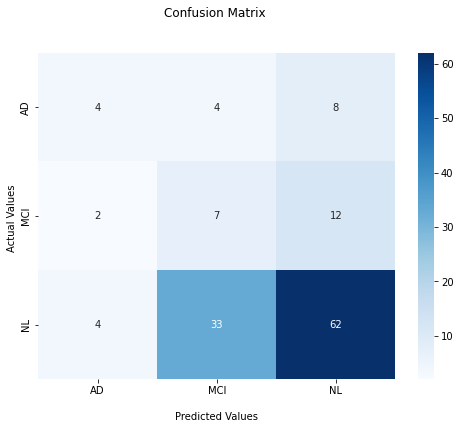

In [ ]:
#Custom 3D CNN model confusion matrix
plot_confusion_matrix(cf_matrix)

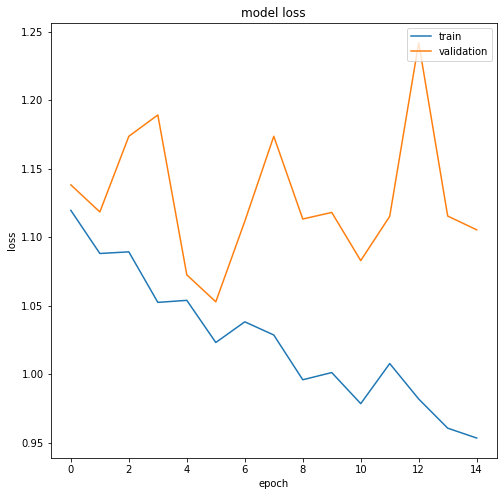

In [ ]:
#Custom 3D CNN model loss graph
plot_model_loss(history)

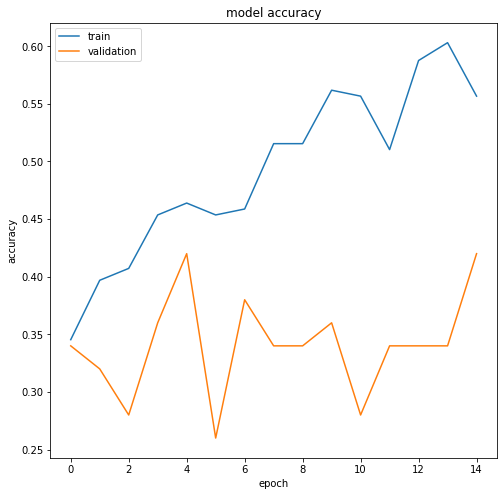

In [ ]:
#Custom 3D CNN model accuracy graph
plot_model_accuracy(history)

# Resnet 3D CNN Model

In [ ]:
#Resnet 3D CNN model


from resnet3d import Resnet3DBuilder
Resnet3D = Resnet3DBuilder.build_resnet_34(
    input_shape=(86,110,78,1),
    num_outputs=3,
    reg_factor=0.01
)

#Dense layer for Resnet 3D CNN model
FC = tf.keras.layers.Dense(512, activation='relu')(Resnet3D.layers[-2].output)
#Dropout Layer for Resnet 3D CNN model
FC = tf.keras.layers.Dropout(0.8)(FC)
#3 way classifcation dense layer
output= tf.keras.layers.Dense(3, activation='softmax')(FC)
model = tf.keras.models.Model(inputs=Resnet3D.input, outputs=output)

#Resnet 3D CNN model compilation
model.compile(loss= "sparse_categorical_crossentropy",
              optimizer = keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics = ["acc"])

#Resnet 3D CNN model callback
checkpoint_cbs = keras.callbacks.ModelCheckpoint(
    "3Dresnet_image_classification.h5", save_best_only=True
)

In [ ]:
#Resnet 3D CNN model fit and train
epochs = 60
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/60
97/97 [==============================] - 27s 207ms/step - loss: 150.2721 - acc: 0.2938 - val_loss: 147.0746 - val_acc: 0.3800
Epoch 2/60
97/97 [==============================] - 19s 198ms/step - loss: 144.3698 - acc: 0.3041 - val_loss: 141.3963 - val_acc: 0.3600
Epoch 3/60
97/97 [==============================] - 19s 199ms/step - loss: 138.6327 - acc: 0.3196 - val_loss: 135.7531 - val_acc: 0.2600
Epoch 4/60
97/97 [==============================] - 19s 200ms/step - loss: 133.0416 - acc: 0.3660 - val_loss: 130.4119 - val_acc: 0.4600
Epoch 5/60
97/97 [==============================] - 19s 201ms/step - loss: 127.5847 - acc: 0.4588 - val_loss: 124.9241 - val_acc: 0.2600
Epoch 6/60
97/97 [==============================] - 19s 201ms/step - loss: 122.3738 - acc: 0.4021 - val_loss: 119.8838 - val_acc: 0.4000
Epoch 7/60
97/97 [==============================] - 20s 201ms/step - loss: 117.6012 - acc: 0.3969 - val_loss: 115.3388 - val_acc: 0.3000
Epoch 8/60
97/97 [=======================

In [ ]:
#Resnet 3D CNN model evaluation
testscores = model.evaluate(test_dataset)
print(f"Accuracy = {testscores[1]*100}")

68/68 [==============================] - 4s 47ms/step - loss: 88.8684 - acc: 0.5368
Accuracy = 53.67646813392639


In [ ]:
#unpacking predictions and labels
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels,y])

#Confusion Matrix
cf_matrix = confusion_matrix(labels, predictions)

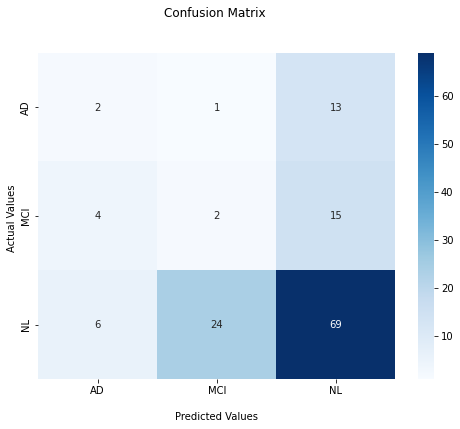

In [ ]:
#Resnet 3D CNN model confusion matrix
plot_confusion_matrix(cf_matrix)

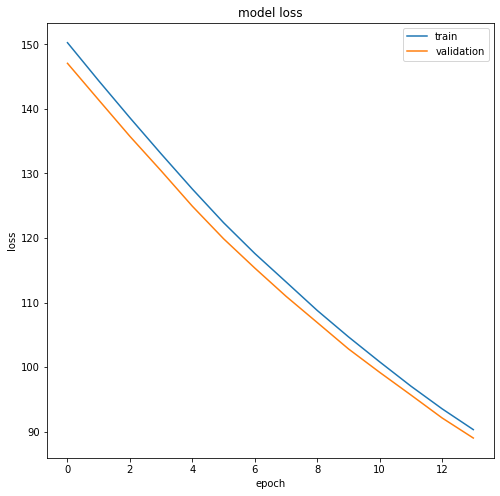

In [ ]:
#Resnet 3D CNN model loss graph
plot_model_loss(history)

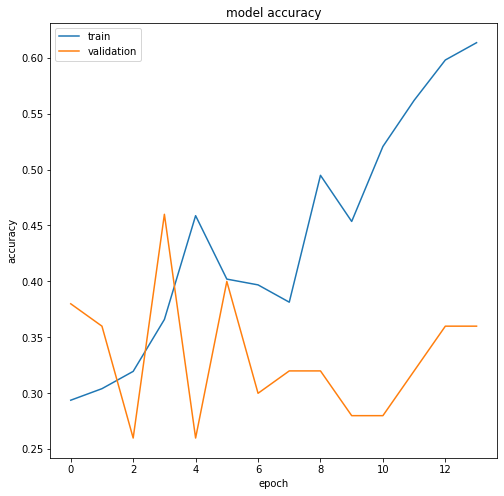

In [ ]:
#Resnet 3D CNN model accuracy graph
plot_model_accuracy(history)